# Use deep neural network to forecast seasonal time series data.

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from dataclasses import dataclass

/Users/jingyiliu/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


1. Sythetic data generating.

In [2]:
# Generate synthetic seasonal data
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(False)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    return np.where(season_time < 0.1,
                    np.cos(season_time * 6 * np.pi), 
                    2 / np.exp(9 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

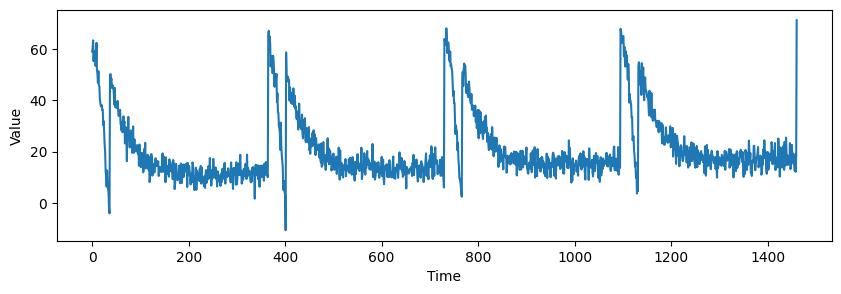

In [3]:
def generate_time_series():
    # The time dimension or the x-coordinate of the time series
    time = np.arange(4 * 365 + 1, dtype="float32")

    # Initial series is just a straight line with a y-intercept
    y_intercept = 10
    slope = 0.005
    series = trend(time, slope) + y_intercept

    # Adding seasonality
    amplitude = 50
    series += seasonality(time, period=365, amplitude=amplitude)

    # Adding some noise
    noise_level = 3
    series += noise(time, noise_level, seed=51)
    
    return time, series

# Save all "global" variables within the G class (G stands for global)
@dataclass
class G:
    TIME, SERIES = generate_time_series()
    SPLIT_TIME = 1100
    WINDOW_SIZE = 20
    BATCH_SIZE = 32
    SHUFFLE_BUFFER_SIZE = 1000
    
# Plot the generated series
plt.figure(figsize=(10, 3))
plot_series(G.TIME, G.SERIES)
plt.show()

In [4]:
def train_val_split(time, series, time_step=G.SPLIT_TIME):

    time_train = time[:time_step]
    series_train = series[:time_step]
    time_valid = time[time_step:]
    series_valid = series[time_step:]

    return time_train, series_train, time_valid, series_valid

time_train, series_train, time_valid, series_valid = train_val_split(G.TIME, G.SERIES)

In [5]:
def windowed_dataset(series, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE):
    
    # Create dataset from the series
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    # Slice the dataset into the appropriate windows
    dataset = dataset.window(window_size+1, shift=1, drop_remainder=True )
    
    # Flatten the dataset
    dataset = dataset.flat_map(lambda window: window.batch(window_size+1))
    
    # Shuffle it
    dataset = dataset.shuffle(shuffle_buffer)
    
    # Split it into the features and labels
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    
    # Batch it
    dataset = dataset.batch(batch_size).prefetch(1)
    
    return dataset

Model architecture design

In [6]:
def create_model(window_size=G.WINDOW_SIZE):
    model = tf.keras.models.Sequential([ 
        tf.keras.layers.Dense(10, input_shape=[window_size], activation='relu'),
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(1)     
    ]) 

    model.compile(loss="mse",
                  optimizer=tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9))

    return model

In [15]:
# Apply the processing to the whole training series
dataset = windowed_dataset(series_train)

# Save an instance of the model
model = create_model()

# Train the model
model.fit(dataset, epochs=100)

Epoch 1/100


/Users/jingyiliu/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 360.2531
Epoch 2/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 473us/step - loss: 42.6229
Epoch 3/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step - loss: 39.1212
Epoch 4/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 436us/step - loss: 29.4845
Epoch 5/100


2024-04-29 18:02:31.000558: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/contextlib.py:135: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(type, value, traceback)
2024-04-29 18:02:31.095067: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-29 18:02:31.150943: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-29 18:02:31.198719: W tensorflow/core/framew

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 450us/step - loss: 42.3234
Epoch 6/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 400us/step - loss: 30.8049
Epoch 7/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 442us/step - loss: 30.2258
Epoch 8/100
 1/34 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 12.0263

2024-04-29 18:02:31.249670: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-29 18:02:31.350960: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-29 18:02:31.402246: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 488us/step - loss: 29.7358
Epoch 9/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step - loss: 33.5471
Epoch 10/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 456us/step - loss: 44.4961
Epoch 11/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 449us/step - loss: 22.2803
Epoch 12/100


2024-04-29 18:02:31.459479: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-29 18:02:31.518738: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-29 18:02:31.572998: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-29 18:02:31.629745: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 554us/step - loss: 27.8089
Epoch 13/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 462us/step - loss: 28.5042
Epoch 14/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 448us/step - loss: 38.8329
Epoch 15/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step - loss: 26.6998
Epoch 16/100


2024-04-29 18:02:31.690415: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-29 18:02:31.747804: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-29 18:02:31.805300: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-29 18:02:31.861108: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step - loss: 32.4577
Epoch 17/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 460us/step - loss: 29.7073
Epoch 18/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 447us/step - loss: 28.4131
Epoch 19/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 470us/step - loss: 26.3670
Epoch 20/100


2024-04-29 18:02:31.918760: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-29 18:02:31.976628: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-29 18:02:32.034011: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-29 18:02:32.092021: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 458us/step - loss: 29.8577
Epoch 21/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 462us/step - loss: 26.0133
Epoch 22/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 452us/step - loss: 33.6183
Epoch 23/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step - loss: 24.5937
Epoch 24/100


2024-04-29 18:02:32.149642: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-29 18:02:32.208582: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-29 18:02:32.265647: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-29 18:02:32.321857: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 504us/step - loss: 40.4706
Epoch 25/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 445us/step - loss: 29.8654
Epoch 26/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 441us/step - loss: 27.1623
Epoch 27/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step - loss: 21.0234
Epoch 28/100


2024-04-29 18:02:32.380125: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-29 18:02:32.438081: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-29 18:02:32.492607: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-29 18:02:32.548105: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 485us/step - loss: 32.1671
Epoch 29/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 459us/step - loss: 26.6165
Epoch 30/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 492us/step - loss: 24.4830
Epoch 31/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step - loss: 26.6110
Epoch 32/100


2024-04-29 18:02:32.603206: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-29 18:02:32.660570: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-29 18:02:32.716919: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-29 18:02:32.773749: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 456us/step - loss: 21.5094
Epoch 33/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 391us/step - loss: 25.2189
Epoch 34/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step - loss: 22.1123
Epoch 35/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 449us/step - loss: 23.9312
Epoch 36/100


2024-04-29 18:02:32.830257: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-29 18:02:32.886446: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-29 18:02:32.969285: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-29 18:02:33.025502: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 466us/step - loss: 28.8267
Epoch 37/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 411us/step - loss: 23.6594
Epoch 38/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 448us/step - loss: 29.0207
Epoch 39/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 438us/step - loss: 20.2846
Epoch 40/100


2024-04-29 18:02:33.078315: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-29 18:02:33.134552: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-29 18:02:33.191938: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-29 18:02:33.247962: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 478us/step - loss: 30.2291
Epoch 41/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 437us/step - loss: 28.1663
Epoch 42/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 455us/step - loss: 27.2748
Epoch 43/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 452us/step - loss: 21.4149
Epoch 44/100


2024-04-29 18:02:33.305949: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-29 18:02:33.363140: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-29 18:02:33.421070: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-29 18:02:33.477712: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 500us/step - loss: 24.2716
Epoch 45/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 467us/step - loss: 24.6964
Epoch 46/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 436us/step - loss: 27.1887
Epoch 47/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 453us/step - loss: 24.0605
Epoch 48/100


2024-04-29 18:02:33.536172: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-29 18:02:33.594810: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-29 18:02:33.652277: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-29 18:02:33.710114: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 447us/step - loss: 24.9870
Epoch 49/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 461us/step - loss: 32.4321
Epoch 50/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 454us/step - loss: 27.1346
Epoch 51/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 437us/step - loss: 30.2647
Epoch 52/100


2024-04-29 18:02:33.768963: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-29 18:02:33.828264: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-29 18:02:33.885708: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-29 18:02:33.942074: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 514us/step - loss: 27.4544
Epoch 53/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step - loss: 26.6348
Epoch 54/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 455us/step - loss: 22.9192
Epoch 55/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 459us/step - loss: 19.8172
Epoch 56/100


2024-04-29 18:02:33.997378: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-29 18:02:34.055332: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-29 18:02:34.112779: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-29 18:02:34.170133: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 509us/step - loss: 27.1730
Epoch 57/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 448us/step - loss: 20.1142
Epoch 58/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 494us/step - loss: 23.5398
Epoch 59/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step - loss: 24.2445
Epoch 60/100


2024-04-29 18:02:34.230169: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-29 18:02:34.288649: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-29 18:02:34.346952: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-29 18:02:34.404076: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 458us/step - loss: 22.3201
Epoch 61/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step - loss: 37.6472
Epoch 62/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 461us/step - loss: 22.4195
Epoch 63/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step - loss: 25.2857
Epoch 64/100


2024-04-29 18:02:34.462718: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-29 18:02:34.521217: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-29 18:02:34.578298: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-29 18:02:34.635260: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 402us/step - loss: 26.2445
Epoch 65/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step - loss: 29.5116
Epoch 66/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 820us/step - loss: 23.6287
Epoch 67/100
 1/34 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 15.2576

2024-04-29 18:02:34.691085: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-29 18:02:34.775155: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-29 18:02:34.844440: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 471us/step - loss: 26.8158
Epoch 68/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 460us/step - loss: 23.1722
Epoch 69/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 427us/step - loss: 24.6356
Epoch 70/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/step - loss: 30.9165
Epoch 71/100


2024-04-29 18:02:34.896597: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-29 18:02:34.955339: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-29 18:02:35.011569: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-29 18:02:35.067977: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 536us/step - loss: 29.0274
Epoch 72/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step - loss: 23.2724
Epoch 73/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 438us/step - loss: 28.2206
Epoch 74/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 443us/step - loss: 24.8790
Epoch 75/100
 1/34 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 10.2609

2024-04-29 18:02:35.127584: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-29 18:02:35.184147: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-29 18:02:35.237885: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-29 18:02:35.289652: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 400us/step - loss: 27.7343
Epoch 76/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step - loss: 33.5743
Epoch 77/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step - loss: 23.6882
Epoch 78/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 453us/step - loss: 28.8985
Epoch 79/100


2024-04-29 18:02:35.336696: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-29 18:02:35.389236: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-29 18:02:35.438260: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-29 18:02:35.495224: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 577us/step - loss: 40.3906
Epoch 80/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 502us/step - loss: 27.3117
Epoch 81/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 445us/step - loss: 23.7753
Epoch 82/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 376us/step - loss: 28.5307
Epoch 83/100


2024-04-29 18:02:35.560978: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-29 18:02:35.620161: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-29 18:02:35.681826: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-29 18:02:35.735677: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step - loss: 21.6370
Epoch 84/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 459us/step - loss: 27.5376
Epoch 85/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 460us/step - loss: 20.7199
Epoch 86/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 451us/step - loss: 28.8472
Epoch 87/100


2024-04-29 18:02:35.791651: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-29 18:02:35.845919: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-29 18:02:35.903599: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-29 18:02:35.960831: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 553us/step - loss: 21.9031
Epoch 88/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 527us/step - loss: 21.7067
Epoch 89/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 453us/step - loss: 32.0380
Epoch 90/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 444us/step - loss: 23.7322
Epoch 91/100


2024-04-29 18:02:36.045905: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-29 18:02:36.102178: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-29 18:02:36.159486: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-29 18:02:36.218716: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 789us/step - loss: 23.4289
Epoch 92/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step - loss: 23.9975
Epoch 93/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step - loss: 21.8619
Epoch 94/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 447us/step - loss: 32.8751
Epoch 95/100


2024-04-29 18:02:36.284795: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-29 18:02:36.367880: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-29 18:02:36.426296: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-29 18:02:36.482986: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step - loss: 27.3882
Epoch 96/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 483us/step - loss: 18.8311
Epoch 97/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step - loss: 25.7391
Epoch 98/100
 1/34 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 39.3096

2024-04-29 18:02:36.544572: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-29 18:02:36.638545: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-29 18:02:36.697647: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 447us/step - loss: 32.5827
Epoch 99/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 466us/step - loss: 24.5897
Epoch 100/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 452us/step - loss: 23.7823


2024-04-29 18:02:36.755082: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-29 18:02:36.813590: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-29 18:02:36.871512: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


In [16]:
def compute_metrics(true_series, forecast):
    
    mse = tf.keras.metrics.mean_squared_error(true_series, forecast).numpy()
    mae = tf.keras.metrics.mean_absolute_error(true_series, forecast).numpy()

    return mse, mae

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/st

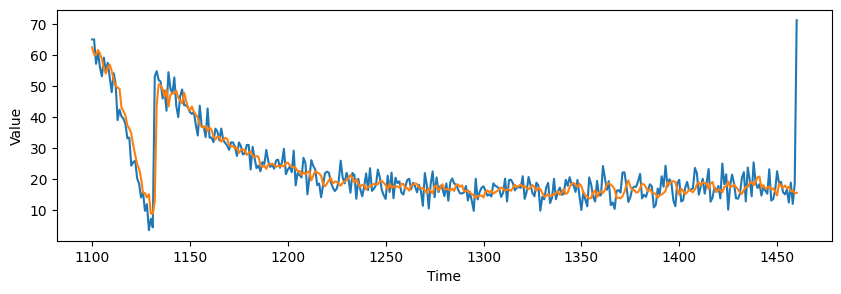

In [17]:
def generate_forecast(series=G.SERIES, split_time=G.SPLIT_TIME, window_size=G.WINDOW_SIZE):
    forecast = []
    for time in range(len(series) - window_size):
        forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

    forecast = forecast[split_time-window_size:]
    results = np.array(forecast)[:, 0, 0]
    return results

# Save the forecast
dnn_forecast = generate_forecast()

# Plot it
plt.figure(figsize=(10, 3))
plot_series(time_valid, series_valid)
plot_series(time_valid, dnn_forecast)

In [20]:
mse, mae = compute_metrics(series_valid, dnn_forecast)
print(f"mse: {mse:.2f}, mae: {mae:.2f} for forecast")

mse: 27.23, mae: 3.08 for forecast
